In [1]:
from itertools import product
import graspy as gp
import numpy as np
import pandas as pd
from hyppo.ksample import Hotelling, KSample
from joblib import Parallel, delayed
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm_notebook as tqdm

from numpy.linalg import norm

from src import estimate_embeddings
%matplotlib inline

sns.set_context("talk")

/home/ubuntu/env/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def rotate(x, angle):
    rads = (angle * np.pi) / 180
    rotated = np.array([
        np.cos(rads) * x[0] - np.sin(rads) * x[1],
        np.sin(rads) * x[0] + np.cos(rads) * x[1],
    ])
    
    return rotated

def find_angle(x, y, target):
    angle = np.arccos(target / (np.linalg.norm(x) * np.linalg.norm(y))) / np.pi * 180
    return angle

def generate_graphs_1(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Change magnitude, keep angle same
    Initial angle of 60 means half of p is off diagonal
    """
    assert (1. + effect_size) <= (1 / p)
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    X3 = X2 * np.sqrt(1+effect_size)

    X = np.vstack(
        [
            np.repeat(np.array([X1]), block_size[0], axis=0),
            np.repeat(np.array([X2]), block_size[1], axis=0)
        ]
        
    )
    Y = np.vstack(
        [
            np.repeat(np.array([X1]), block_size[0], axis=0),
            np.repeat(np.array([X3]), block_size[1], axis=0)
        ]
    )

    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

def generate_graphs_4(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Initial angle of 60 means half of p is off diagonal
    """
    assert (1. + effect_size) <= (1 / p)
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    off_diag = X1 @ X2
    X3 = X2 * np.sqrt(1+effect_size)
    X3 = rotate(X3, find_angle(X1, X3, off_diag)-initial_angle)

    X = np.vstack(
        [
            np.repeat(np.array([X1]), block_size[0], axis=0),
            np.repeat(np.array([X2]), block_size[1], axis=0)
        ]
        
    )
    Y = np.vstack(
        [
            np.repeat(np.array([X1]), block_size[0], axis=0),
            np.repeat(np.array([X3]), block_size[1], axis=0)
        ]
    )
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

In [3]:
def compute_pr_at_k(pvals, k, true_labels):
    """
    1 is considered the significant nodes
    """
    idx = np.argsort(pvals)
    sorted_labels = true_labels[idx]
    
    precision = sorted_labels[:k].mean()
    #recall = sorted_labels[:k].sum() / sorted_labels.sum()
    
    return precision


def experiment(m, block_1, block_2, p, effect_size, generate_func, reps=100):
    m_per_pop = m // 2
    block_size = np.array([block_1, block_2])
    
    n = block_1 + block_2
    labels = np.array([0] * block_1 + [1] * block_2)

    def worker():
        pvals = np.zeros((3, n))
        X, Y = generate_func(p, effect_size, block_size, m_per_pop)

        for node in range(n):
            try:
                X_node = np.delete(X[:, node, :], node, axis=1)
                Y_node = np.delete(Y[:, node, :], node, axis=1)
                test = Hotelling().test(X_node, Y_node)
                #test = KSample('Dcorr').test(X_node, Y_node, reps=500)
                if np.isnan(test[1]):
                    pvals[0, node] = 0
                else:
                    pvals[0, node] = test[1]
            except:
                pvals[0, node] = 1

        for j, method in enumerate(['omni', 'mase'], start=1):
            embeddings = estimate_embeddings(X, Y, method, 2, sample_space=True)
            Xhat = embeddings[:m_per_pop]
            Yhat = embeddings[m_per_pop:]
            for node in range(n):
                try:
                    test = Hotelling().test(Xhat[:, node, :], Yhat[:, node, :])
                    pvals[j, node] = test[1]
                except:
                    pvals[j, node] = 1

        
        p_at_k = np.array([compute_pr_at_k(pvals[i], block_2, labels) for i in range(3)])
        
        pvals_binary = (pvals <= 0.05) * 1
        
        f1 = np.array([f1_score(labels, pvals_binary[i]) for i in range(3)])
                
        conf = np.array(
            [confusion_matrix(labels, pvals_binary[i]).ravel() for i in range(3)]
        )
        #tn, fp, fn, tp
        fp = conf[:, 1] / n
        tp = conf[:, 3] / n
        
        return pvals, p_at_k, f1, fp, tp
    
    res = Parallel(-1)(delayed(worker)() for _ in range(reps))
    precs = np.array([res[i][1] for i in range(reps)]).mean(axis=0)
    f1s = np.array([res[i][2] for i in range(reps)]).mean(axis=0)
    fps = np.array([res[i][3] for i in range(reps)]).mean(axis=0)
    tps = np.array([res[i][4] for i in range(reps)]).mean(axis=0)
    
    pvals = np.array([res[i][0] for i in range(reps)])
    pvals = np.array(pvals)
    pvals = (pvals < 0.05).mean(axis=0)
    avg_pval_1 = pvals[:, :block_1].mean(axis=1)
    avg_pval_2 = pvals[:, block_1:].mean(axis=1)

    to_append = [m, block_1, block_2, effect_size, 
                 generate_func.__name__, *avg_pval_1, *avg_pval_2, *precs, *f1s, *fps, *tps]
    return to_append

In [6]:
m = 200
#block_1s = np.arange(9, 76, 3) #51
block_2s = np.arange(1, 70) # 51
block_1s = 70 - block_2s
block_sizes = list(zip(block_1s, block_2s))
effect_size = 1
generate_funcs = [generate_graphs_1, generate_graphs_4]
p = 0.25

args = [
    dict(p=p, 
         m=m, 
         block_1=block_1, 
         block_2=block_2, 
         effect_size=effect_size, 
         generate_func=generate_func) 
    for (block_1, block_2), generate_func
    in product(block_sizes, generate_funcs)
]

In [9]:
res = []
for arg in tqdm(args):
    res.append(experiment(**arg))

In [10]:
columns = ["m", "block_1", "block_2", "effect_size", "model",
           "row_wise_same", "omni_same", "mase_same", 
           "row_wise_diff", "omni_diff", "mase_diff",
           "row_wise_precision", "omni_precision", "mase_precision",
           "row_wise_f1", "omni_f1", "mase_f1",
           "row_wise_fp", "omni_fp", "mase_fp",
           "row_wise_tp", "omni_tp", "mase_tp",
  ]

df = pd.DataFrame(res, columns=columns)
df.to_csv("./results/20200610_validity.csv", index=False)

In [11]:
df

,m,block_1,block_2,effect_size,model,row_wise_same,omni_same,mase_same,row_wise_diff,omni_diff,...,mase_precision,row_wise_f1,omni_f1,mase_f1,row_wise_fp,omni_fp,mase_fp,row_wise_tp,omni_tp,mase_tp
0,200,69,1,1,generate_graphs_1,0.051739,0.050435,0.047246,0.640,1.00,...,0.030000,0.245254,0.418548,0.005949,0.051000,0.049714,0.046571,0.009143,0.014286,0.001000
1,200,69,1,1,generate_graphs_4,0.053333,0.054203,0.063913,0.050,0.05,...,0.000000,0.018190,0.021222,0.002133,0.052571,0.053429,0.063000,0.000714,0.000714,0.000714
2,200,68,2,1,generate_graphs_1,0.050000,0.053382,0.131618,0.625,1.00,...,0.025000,0.388164,0.558383,0.017740,0.048571,0.051857,0.127857,0.017857,0.028571,0.004571
3,200,68,2,1,generate_graphs_4,0.049559,0.051324,0.058382,0.070,0.06,...,0.045000,0.046398,0.041056,0.004265,0.048143,0.049857,0.056714,0.002000,0.001714,0.001286
4,200,67,3,1,generate_graphs_1,0.060896,0.053433,0.164030,0.760,1.00,...,0.076667,0.499229,0.642228,0.039374,0.058286,0.051143,0.157000,0.032571,0.042857,0.009571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,200,3,67,1,generate_graphs_4,0.030000,0.030000,1.000000,1.000,1.00,...,0.955224,0.999333,0.999333,0.978102,0.001286,0.001286,0.042857,0.957143,0.957143,0.957143
134,200,2,68,1,generate_graphs_1,0.605000,1.000000,1.000000,1.000,1.00,...,0.970588,0.991208,0.985507,0.985507,0.017286,0.028571,0.028571,0.971429,0.971429,0.971429
135,200,2,68,1,generate_graphs_4,0.045000,0.065000,1.000000,1.000,1.00,...,0.970588,0.999343,0.999052,0.985507,0.001286,0.001857,0.028571,0.971429,0.971429,0.971429
136,200,1,69,1,generate_graphs_1,0.600000,1.000000,1.000000,1.000,1.00,...,0.985507,0.995683,0.992806,0.992806,0.008571,0.014286,0.014286,0.985714,0.985714,0.985714


In [12]:
tmp = df[df.model == "generate_graphs_4"]

row = tmp.omni_same.values.reshape(23, -1)

<ipython-input-12-8bf979107bcd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df.model == "generate_graphs_4"][df.effect_size==1]


In [36]:
tmp.row_wise_tp * 70 / block_2s

AttributeError: 'DataFrame' object has no attribute 'omni_wise_tp'

Text(0.5, -0.03, 'Number of Significant Vertices')

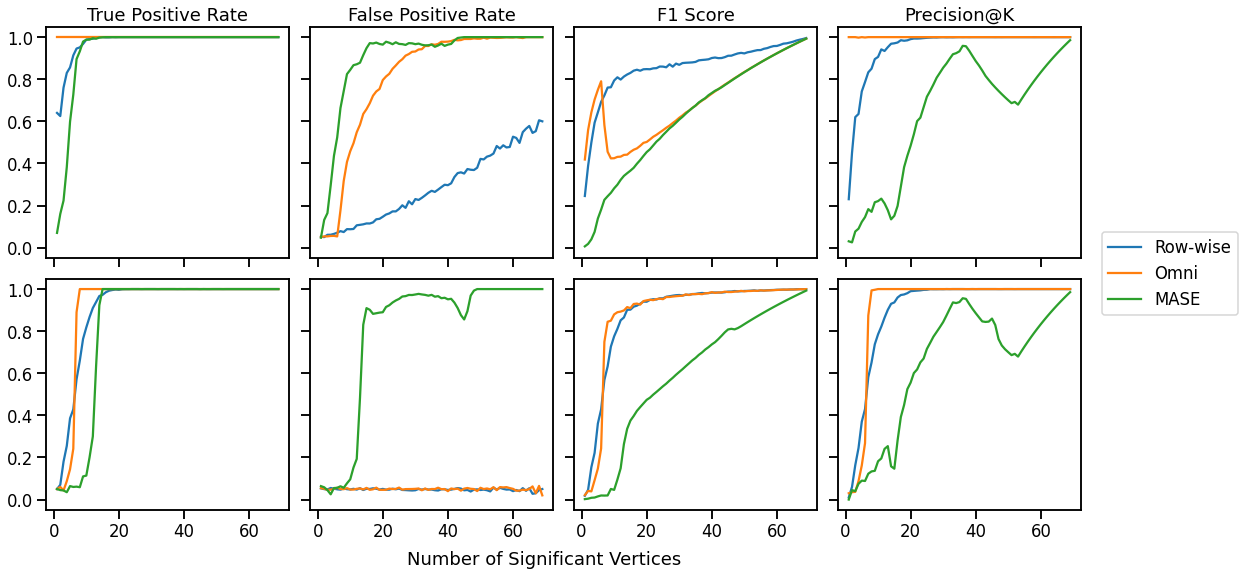

In [58]:
fig, ax = plt.subplots(ncols=4, nrows=2, sharex=True, sharey=True, figsize=(15, 7.5), constrained_layout=True)


for i, model in enumerate(np.unique(df.model)):
    tmp = df[df.model == model]

    sns.lineplot(tmp.block_2, tmp.row_wise_tp * 70 / block_2s, ax = ax[i, 0], label="Row-wise")
    sns.lineplot(tmp.block_2, tmp.omni_tp* 70 / block_2s, ax = ax[i, 0], label="Omni")
    sns.lineplot(tmp.block_2, tmp.mase_tp* 70 / block_2s, ax = ax[i, 0], label="MASE")

    sns.lineplot(tmp.block_2, tmp.row_wise_fp * 70 / block_1s, ax = ax[i, 1])
    sns.lineplot(tmp.block_2, tmp.omni_fp * 70 / block_1s, ax = ax[i, 1])
    sns.lineplot(tmp.block_2, tmp.mase_fp * 70 / block_1s, ax = ax[i, 1])


    sns.lineplot(tmp.block_2, tmp.row_wise_f1, ax = ax[i, 2])
    sns.lineplot(tmp.block_2, tmp.omni_f1, ax = ax[i, 2])
    sns.lineplot(tmp.block_2, tmp.mase_f1, ax = ax[i, 2])


    sns.lineplot(tmp.block_2, tmp.row_wise_precision, ax = ax[i, 3])
    sns.lineplot(tmp.block_2, tmp.omni_precision, ax = ax[i, 3])
    sns.lineplot(tmp.block_2, tmp.mase_precision, ax = ax[i, 3])
    
    for idx in range(4):
        ax[i, idx].set_ylabel("")
        ax[i, idx].set_xlabel("")
    
    #ax[0, 0].set_xlim(-1, 71)
    
    if i == 0:
        titles = ["True Positive Rate", "False Positive Rate", "F1 Score", "Precision@K"]
        for j, title in enumerate(titles):
            ax[0, j].set_title(title)
            
            
    handles, labels = ax[i, 0].get_legend_handles_labels()
    
    ax[i, 0].get_legend().remove()
    
# legend = fig.legend(
#     handles, 
#     labels,
#     ncol = 7, 
#     loc='lower center',
#     bbox_to_anchor=(.515, -0.15),
#     bbox_transform=plt.gcf().transFigure
# )

legend = fig.legend(
    handles, 
    labels,
    ncol = 1, 
    loc='center right',
    bbox_to_anchor=(1.15, .5),
    bbox_transform=plt.gcf().transFigure
)


fig.text(0.5, -0.03, "Number of Significant Vertices", va="center", ha="center")

In [ ]:
fig.savefig("20200610_final.png", dpi=300, bbox_inches='tight')